In [53]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

%run ../src/utility.py

np.random.seed(1231)

```
In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 

```

In [26]:
# load files

# age_gender_bkts = pd.read_csv('../data/age_gender_bkts.csv')
# countries       = pd.read_csv('../data/countries.csv')
train           = pd.read_csv('../data/train_users_2.csv', parse_dates=[1, 3])
test            = pd.read_csv('../data/test_users.csv', parse_dates=[1, 3])
# sub             = pd.read_csv('../data/sample_submission_NDF.csv')

` country_destination is the target variable `

In [17]:
count_missing_values(train)

{'affiliate_channel': 0,
 'affiliate_provider': 0,
 'age': 87990,
 'country_destination': 0,
 'date_account_created': 0,
 'date_first_booking': 124543,
 'first_affiliate_tracked': 6065,
 'first_browser': 0,
 'first_device_type': 0,
 'gender': 0,
 'id': 0,
 'language': 0,
 'signup_app': 0,
 'signup_flow': 0,
 'signup_method': 0,
 'timestamp_first_active': 0}

In [18]:
count_missing_values(test)

{'affiliate_channel': 0,
 'affiliate_provider': 0,
 'age': 28876,
 'date_account_created': 0,
 'date_first_booking': 62096,
 'first_affiliate_tracked': 20,
 'first_browser': 0,
 'first_device_type': 0,
 'gender': 0,
 'id': 0,
 'language': 0,
 'signup_app': 0,
 'signup_flow': 0,
 'signup_method': 0,
 'timestamp_first_active': 0}

** Age, Date of first booking and First Affiliate Tracked have missing values **

In [27]:
# concat train and test

ntrain = len(train)
data   = pd.concat((train, test))
target = train.country_destination

In [28]:
data = data.drop(labels='country_destination', axis=1)
del train, test

In [32]:
# list of features captured
data.columns

Index(['affiliate_channel', 'affiliate_provider', 'age',
       'date_account_created', 'date_first_booking', 'first_affiliate_tracked',
       'first_browser', 'first_device_type', 'gender', 'id', 'language',
       'signup_app', 'signup_flow', 'signup_method', 'timestamp_first_active'],
      dtype='object')

** Let's look at affliate channel: What kind of paid marketing ? **

In [37]:
# categorical variable
print('Feature type: %s'%(data.affiliate_channel.dtype))

Feature type: object


In [38]:
data.affiliate_channel.value_counts()

direct           181571
sem-brand         36439
sem-non-brand     20075
seo               14362
other              9547
api                8167
content            4118
remarketing        1268
Name: affiliate_channel, dtype: int64

In [109]:
# is there any relationship between target and this feature
affiliate_channel_rel = pd.crosstab(data.iloc[:ntrain]['affiliate_channel'],  target)

In [110]:
affiliate_channel_rel

country_destination,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other
affiliate_channel,,,,,,,,,,,,
api,17,30,22,56,87,60,50,5382,20,1,2124,318
content,7,17,5,26,57,7,21,3390,8,1,327,82
direct,363,945,699,1536,3294,1579,1858,78329,503,144,41725,6752
other,10,70,35,34,115,44,63,5361,12,8,2969,240
remarketing,1,7,5,21,35,13,17,728,2,1,225,41
sem-brand,65,154,137,278,669,329,463,14951,103,37,7725,1134
sem-non-brand,59,147,112,180,533,193,242,11694,80,17,4552,1035
seo,17,58,46,118,233,99,121,4708,34,8,2729,492


In [122]:
def plot_variable_distribution(df, indices, dim):
    fig, ax = plt.subplots(dim, dim, sharey=False, figsize=(15, 15))
    
    for i, col in enumerate(indices):
        
        curr_ax  = ax[int(i/dim)][i%dim]
        curr_ax.set_xticklabels(df.columns) # set labels for x-axis
        curr_ax.set_title(df.ix[col].name)  # set title for each of the subplots
        
        df.ix[col].plot(ax=curr_ax)
        
        plt.setp(curr_ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    
    
def plot_crosstab_distribution(df):
    num_categories = df.index.nunique()
    categories     = df.index.unique()
    
    dim = int(np.ceil(num_categories ** 0.5))
    plot_variable_distribution(df, categories, dim)

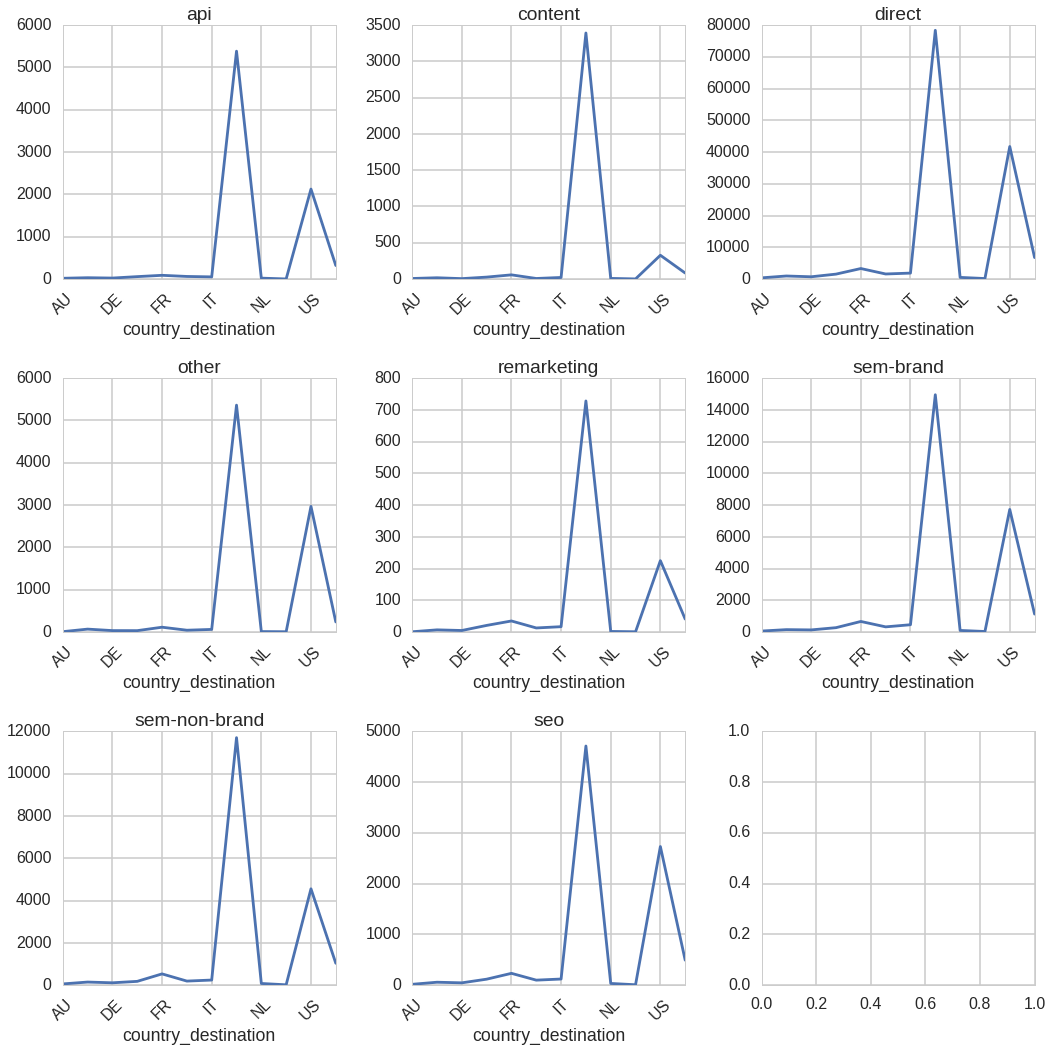

In [124]:
plot_crosstab_distribution(affiliate_channel_rel)

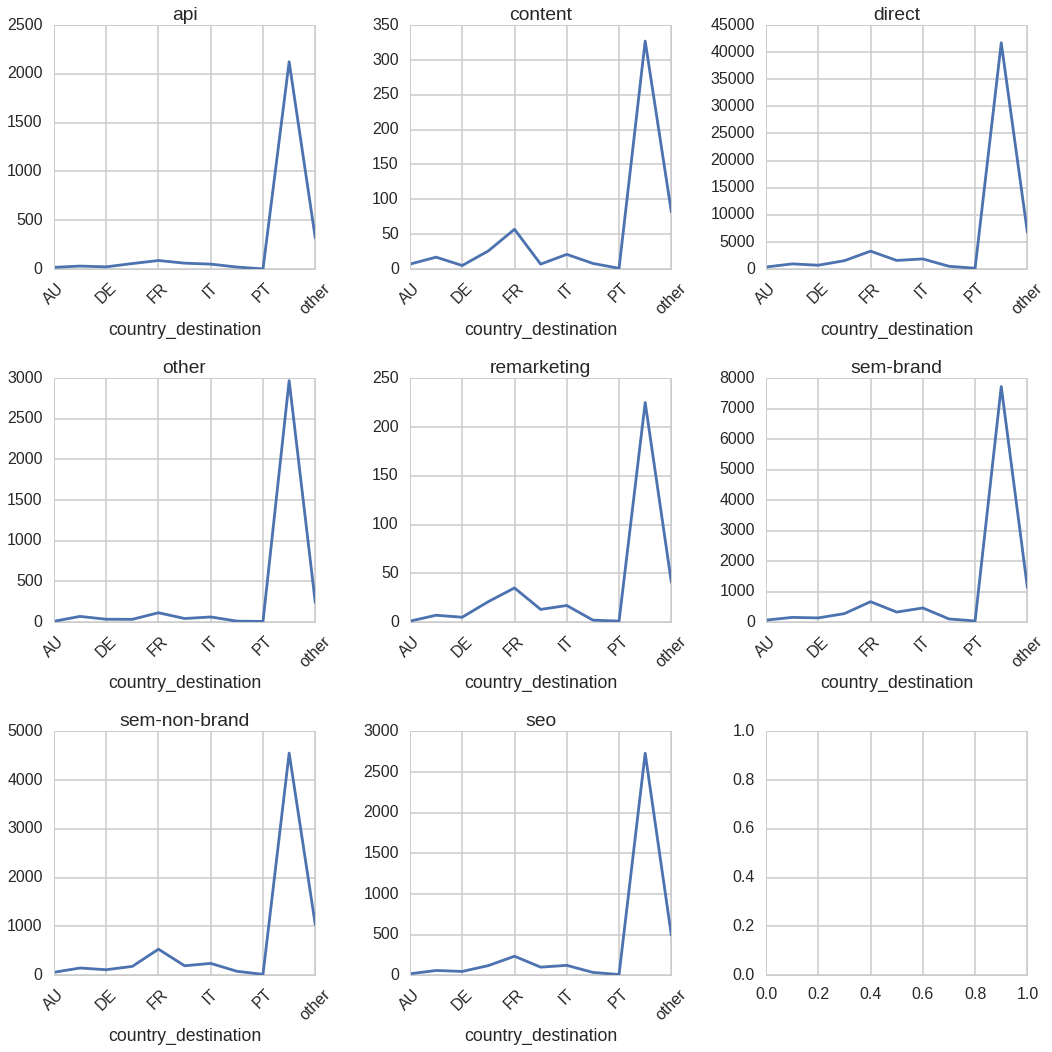

In [125]:
# exclude NDF
plot_crosstab_distribution(affiliate_channel_rel[affiliate_channel_rel.columns.drop('NDF')])

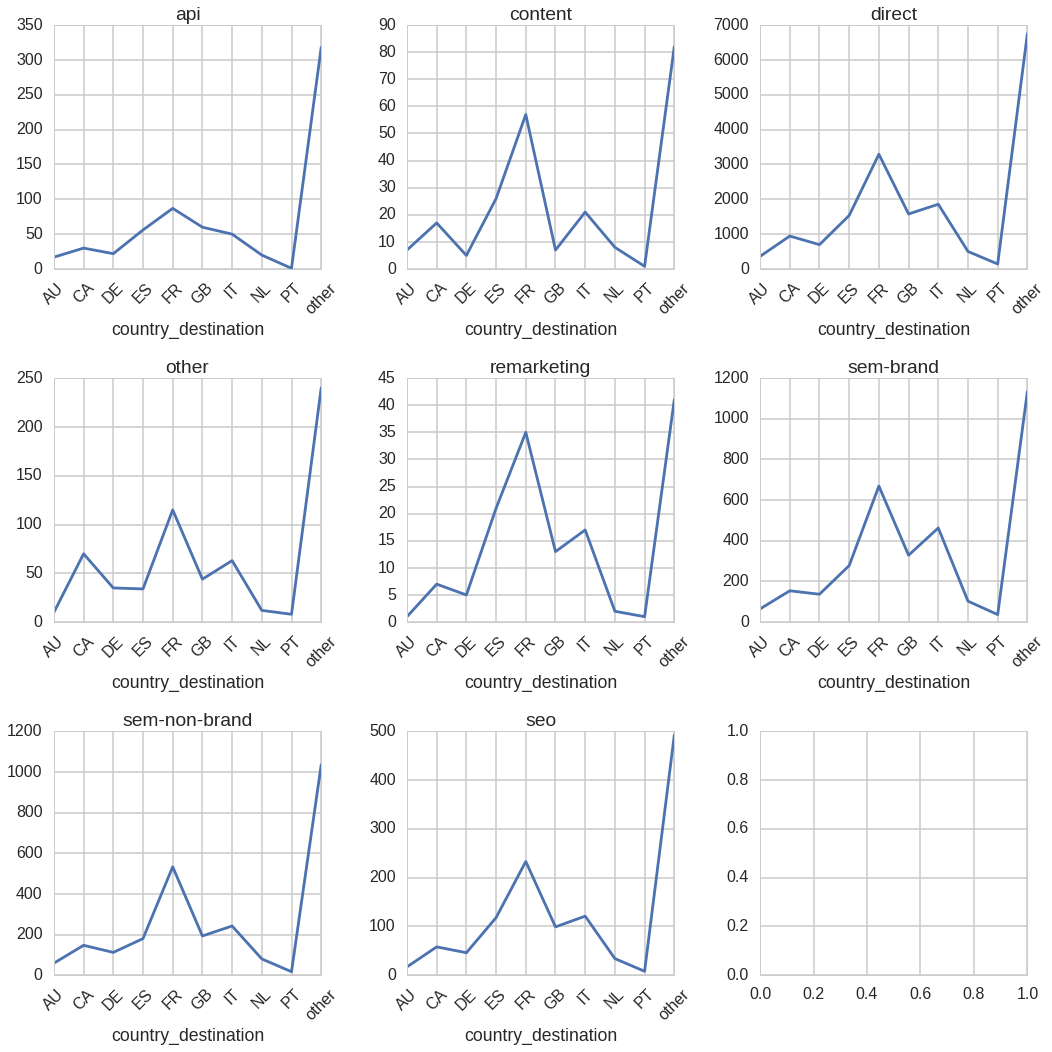

In [127]:
# exclude NDF and US
plot_crosstab_distribution(affiliate_channel_rel[affiliate_channel_rel.columns.drop(['NDF', 'US'])])